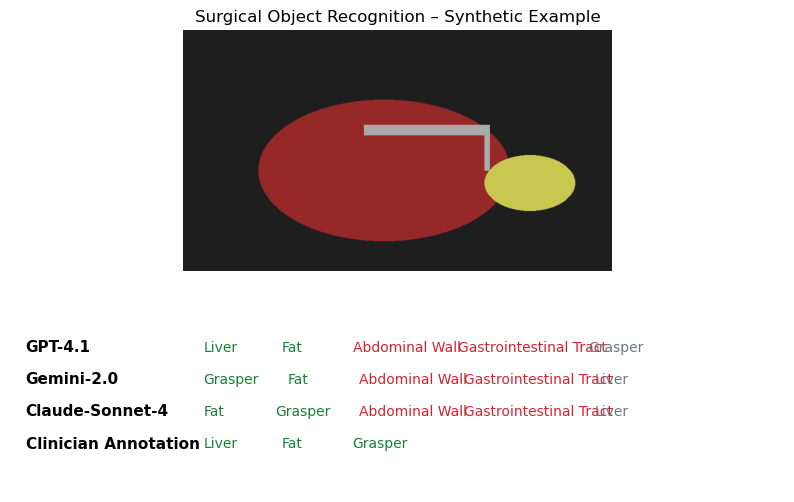

,Row,Colored Tokens
0,GPT-4.1,[green] Liver [green] Fat [red] Abdominal Wall...
1,Gemini-2.0,[green] Grasper [green] Fat [red] Abdominal Wa...
2,Claude-Sonnet-4,[green] Fat [green] Grasper [red] Abdominal Wa...
3,Clinician Annotation,[green] Liver [green] Fat [green] Grasper


In [4]:
# The environment doesn't have caas_jupyter_tools. We'll just show the dataframe directly
# with a normal print instead of using a display helper.
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SAVE_FIG_PATH = "surgical_tag_compare.png"
SAVE_CSV_PATH = "surgical_tag_rows.csv"

# Reuse previously defined ID2LABEL, LABEL_IDS, COLOR_CLASS_MAPPING, RELATED_MAP
ID2LABEL = {
    0: "Black Background",
    1: "Abdominal Wall",
    2: "Liver",
    3: "Gastrointestinal Tract",
    4: "Fat",
    5: "Grasper",
    6: "Connective Tissue",
    7: "Blood",
    8: "Cystic Duct",
    9: "L-hook Electrocautery",
    10: "Gallbladder",
    11: "Hepatic Vein",
    12: "Liver Ligament",
}
LABEL_IDS = [k for k in sorted(ID2LABEL) if k != 0]

RELATED_MAP = {
    "grasper": {"grasper", "forceps", "bipolar forceps"},
    "gallbladder": {"gallbladder", "gb"},
    "l-hook electrocautery": {"l-hook electrocautery", "hook", "electrocautery tool"},
    "gastrointestinal tract": {"gastrointestinal tract", "stomach", "intestine", "bowel"},
    "liver": {"liver", "hepatic"},
    "fat": {"fat", "fatty tissue", "omentum"},
    "blood": {"blood", "bleeding"},
    "hepatic vein": {"hepatic vein", "vein"},
    "liver ligament": {"liver ligament", "ligament"},
    "cystic duct": {"cystic duct", "duct"},
    "abdominal wall": {"abdominal wall", "wall"},
    "connective tissue": {"connective tissue", "tissue"},
}

# Synthesize example
def synthetic_example():
    w, h = 854, 480
    img = Image.new("RGB", (w, h), (30, 30, 30))
    drw = ImageDraw.Draw(img)
    drw.ellipse((150, 140, 650, 420), fill=(150, 40, 40))  # Liver
    drw.ellipse((600, 250, 780, 360), fill=(200, 200, 80))  # Fat
    drw.rectangle((360, 190, 610, 210), fill=(170, 170, 170))  # Grasper
    drw.rectangle((600, 200, 610, 280), fill=(170, 170, 170))
    return img

img_pil = synthetic_example()
clinician_tags = ["Liver", "Fat", "Grasper"]

def pick_preds(gt):
    all_tags = [ID2LABEL[i] for i in LABEL_IDS]
    wrong = [t for t in all_tags if t not in gt]
    return gt[:2] + wrong[:2]

model_pred_tags = {
    "GPT-4.1": pick_preds(clinician_tags),
    "Gemini-2.0": pick_preds(clinician_tags[::-1]),
    "Claude-Sonnet-4": pick_preds(clinician_tags[1:] + clinician_tags[:1]),
}

def colorize_predictions(pred_list, gt_list):
    gt_set = set([g.lower() for g in gt_list])
    tokens = []
    for p in pred_list:
        p_l = p.lower()
        if p_l in gt_set:
            tokens.append(("green", p))
        else:
            related_hit = False
            for _, syns in RELATED_MAP.items():
                if p_l in syns and any(g.lower() in syns for g in gt_set):
                    related_hit = True
                    break
            if related_hit:
                tokens.append(("yellow", p))
            else:
                tokens.append(("red", p))
    missing = [g for g in gt_list if g not in pred_list]
    for m in missing:
        tokens.append(("grey", m))
    return tokens

rows_data = {model: colorize_predictions(preds, clinician_tags) for model, preds in model_pred_tags.items()}
rows_data["Clinician Annotation"] = [("green", t) for t in clinician_tags]

# Draw figure
plt.figure(figsize=(10, 6))
gs = plt.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.3)

ax_img = plt.subplot(gs[0])
ax_img.imshow(img_pil)
ax_img.axis("off")
ax_img.set_title("Surgical Object Recognition – Synthetic Example")

ax_tbl = plt.subplot(gs[1])
ax_tbl.axis("off")
row_order = list(model_pred_tags.keys()) + ["Clinician Annotation"]
y0, dy = 0.9, 0.2
for i, name in enumerate(row_order):
    y = y0 - i * dy
    ax_tbl.text(0.02, y, name, fontsize=11, fontweight="bold", va="center")
    x = 0.25
    for (color, token) in rows_data[name]:
        c = {"green": "#1a7f37", "red": "#d1242f", "yellow": "#d29922", "grey": "#6e7781"}[color]
        ax_tbl.text(x, y, token, fontsize=10, color=c, va="center")
        x += 0.08 + len(token)*0.004

plt.savefig(SAVE_FIG_PATH, bbox_inches="tight")
plt.show()

def join_color_tokens(toklist):
    return " ".join([f"[{c}] {t}" for (c, t) in toklist])

df = pd.DataFrame({
    "Row": row_order,
    "Colored Tokens": [join_color_tokens(rows_data[name]) for name in row_order]
})
df.to_csv(SAVE_CSV_PATH, index=False)

df.head()


In [2]:
!pip install caas_jupyter_tools

ERROR: Could not find a version that satisfies the requirement caas_jupyter_tools (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for caas_jupyter_tools


# Method 2

In [6]:
# Build a LaTeX table that EMBEDS the example images into the table cells
from pathlib import Path

outdir = Path("figures")

# Filenames relative to a typical LaTeX project folder named "figures/"
examples_rel = [f"figures/example_{i}.pdf" for i in range(1, 4)]

# Colored tag rows (same placeholders as before)
GREEN = r"green!45!black"
RED = r"red!70!black"
YELLOW = r"orange!80!black"
GREY = r"gray"

def colored(tags):
    # tags is list of (text, color_name)
    parts = []
    for t, c in tags:
        parts.append(rf"\textcolor{{{c}}}{{{t}}}")
    return r", ".join(parts)

rows_for_tex = {
    "RAVS (Ours)": [
        [("bipolar", GREEN), ("liver", GREEN), ("grasper", GREEN), ("retract", GREEN), ("coagulate", GREEN)],
        [("liver", GREEN), ("robotic arms", GREEN), ("stomach", GREEN), ("grasper", GREEN), ("omentum", GREY)],
        [("harmonic scalpel", GREEN), ("spleen", GREEN), ("stomach", GREEN), ("fatty tissue", GREY)],
    ],
    "Model A (Open-VLM)": [
        [("blood", RED), ("disease", RED), ("person", RED), ("tool", YELLOW), ("tube", YELLOW)],
        [("blood", RED), ("doctor", RED), ("equipment", YELLOW), ("operating room", YELLOW)],
        [("battery", RED), ("eye", RED), ("injection", RED), ("tissue", YELLOW)],
    ],
    "Model B (Commercial API)": [
        [("liver", GREEN), ("laparoscopic instrument", RED), ("electrocautery tool", RED), ("tissue", RED)],
        [("stomach", GREEN), ("omentum", GREEN), ("robotic arms", GREEN), ("grasper", GREEN), ("bipolar forceps", RED)],
        [("stomach", GREEN), ("fatty tissue", GREEN), ("harmonic scalpel", GREEN), ("spleen", GREEN)],
    ],
    "Clinician Annotation": [
        [("bipolar", GREEN), ("liver", GREEN), ("grasper", GREEN), ("retract", GREEN), ("coagulate", GREEN)],
        [("robotic arms", GREEN), ("liver", GREEN), ("omentum", GREEN), ("grasper", GREEN), ("stomach", GREEN)],
        [("harmonic scalpel", GREEN), ("stomach", GREEN), ("fatty tissue", GREEN), ("spleen", GREEN)],
    ],
}

# Create the LaTeX table
header_images = " & " + " & ".join([rf"\includegraphics[width=0.28\textwidth]{{{p}}}" for p in examples_rel]) + r" \\"
methods_rows = []
for method, cells in rows_for_tex.items():
    row = rf"{method} & " + " & ".join([colored(cell) for cell in cells]) + r" \\"
    methods_rows.append(row)

latex_table_with_images = r"""
% Requires: \usepackage{graphicx}, \usepackage{xcolor}, \usepackage{booktabs}, \usepackage{tabularx} (optional)
\begin{table*}[t]
\centering
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1.25}
\begin{tabular}{lccc}
\toprule
 & Example 1 & Example 2 & Example 3 \\
\midrule
"""[1:] + header_images + "\n\\midrule\n" + "\n".join(methods_rows) + r"""
\bottomrule
\end{tabular}
\caption{\textbf{Surgical object recognition with images embedded in the table.} Each column shows a representative frame. 
Colored tags: \textcolor{green!45!black}{green} = correct; \textcolor{red!70!black}{red} = wrong; \textcolor{orange!80!black}{yellow} = partially related; \textcolor{gray}{grey} = missing.}
\label{tab:organ-recognition}
\end{table*}
"""

# Save a .tex snippet for convenience
with open(outdir / "table_organ_recognition_with_images.tex", "w") as f:
    f.write(latex_table_with_images)

print("Saved LaTeX table (with embedded images) to: /mnt/data/figures/table_organ_recognition_with_images.tex")
print("\nPaste this into your paper:\n")
print(latex_table_with_images)


Saved LaTeX table (with embedded images) to: /mnt/data/figures/table_organ_recognition_with_images.tex

Paste this into your paper:

% Requires: \usepackage{graphicx}, \usepackage{xcolor}, \usepackage{booktabs}, \usepackage{tabularx} (optional)
\begin{table*}[t]
\centering
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1.25}
\begin{tabular}{lccc}
\toprule
 & Example 1 & Example 2 & Example 3 \\
\midrule
 & \includegraphics[width=0.28\textwidth]{figures/example_1.pdf} & \includegraphics[width=0.28\textwidth]{figures/example_2.pdf} & \includegraphics[width=0.28\textwidth]{figures/example_3.pdf} \\
\midrule
RAVS (Ours) & \textcolor{green!45!black}{bipolar}, \textcolor{green!45!black}{liver}, \textcolor{green!45!black}{grasper}, \textcolor{green!45!black}{retract}, \textcolor{green!45!black}{coagulate} & \textcolor{green!45!black}{liver}, \textcolor{green!45!black}{robotic arms}, \textcolor{green!45!black}{stomach}, \textcolor{green!45!black}{grasper}, \textcolor{gray}{omentum} &

In [7]:
# Python to regenerate the synthesized image (same as before) and
# produce a LaTeX table that embeds the image and includes the
# requested model rows: GPT, Gemini, Claude, Llava, Pixtral, Qwen,
# PeskaVLP, RASO + Clinician Annotation.
from pathlib import Path
from PIL import Image, ImageDraw
import random

# -----------------------------
# Output paths
# -----------------------------
figdir = Path("figures")
figdir.mkdir(parents=True, exist_ok=True)
img_pdf = figdir / "synth_example.pdf"
img_png = figdir / "synth_example.png"
tex_path = figdir / "table_synth_with_all_models.tex"

# -----------------------------
# Synthesized image generator (exact geometry/colors as you gave)
# -----------------------------
def synthetic_example():
    w, h = 854, 480
    img = Image.new("RGB", (w, h), (30, 30, 30))
    drw = ImageDraw.Draw(img)
    drw.ellipse((150, 140, 650, 420), fill=(150, 40, 40))  # Liver
    drw.ellipse((600, 250, 780, 360), fill=(200, 200, 80))  # Fat
    drw.rectangle((360, 190, 610, 210), fill=(170, 170, 170))  # Grasper
    drw.rectangle((600, 200, 610, 280), fill=(170, 170, 170))
    return img

img = synthetic_example()
img.save(img_png)
img.convert("RGB").save(img_pdf)

# -----------------------------
# Taxonomy + related map (for partial matches) + ground truth
# -----------------------------
ID2LABEL = {
    1: "Abdominal Wall",
    2: "Liver",
    3: "Gastrointestinal Tract",
    4: "Fat",
    5: "Grasper",
    6: "Connective Tissue",
    7: "Blood",
    8: "Cystic Duct",
    9: "L-hook Electrocautery",
    10: "Gallbladder",
    11: "Hepatic Vein",
    12: "Liver Ligament",
}
LABELS = list(ID2LABEL.values())

RELATED_MAP = {
    "grasper": {"grasper", "forceps", "bipolar forceps"},
    "gallbladder": {"gallbladder", "gb"},
    "l-hook electrocautery": {"l-hook electrocautery", "hook", "electrocautery tool"},
    "gastrointestinal tract": {"gastrointestinal tract", "stomach", "intestine", "bowel"},
    "liver": {"liver", "hepatic"},
    "fat": {"fat", "fatty tissue", "omentum"},
    "blood": {"blood", "bleeding"},
    "hepatic vein": {"hepatic vein", "vein"},
    "liver ligament": {"liver ligament", "ligament"},
    "cystic duct": {"cystic duct", "duct"},
    "abdominal wall": {"abdominal wall", "wall"},
    "connective tissue": {"connective tissue", "tissue"},
}

GT = ["Liver", "Fat", "Grasper"]

# -----------------------------
# Make placeholder predictions for each requested model
# -----------------------------
models = ["GPT", "Gemini", "Claude", "Llava", "Pixtral", "Qwen", "PeskaVLP", "RASO"]

def make_preds(seed):
    r = random.Random(seed)
    preds = []
    # include 2 GT tokens
    preds.extend(r.sample(GT, 2))
    # add 2 random non-GT tokens
    non_gt = [x for x in LABELS if x not in GT]
    preds.extend(r.sample(non_gt, 2))
    return preds

def colorize(preds, gt_list):
    gt_set = set(g.lower() for g in gt_list)
    tokens = []
    for p in preds:
        pl = p.lower()
        if pl in gt_set:
            tokens.append(("green", p))
        else:
            related = any(pl in syns and any(g in syns for g in gt_set)
                          for key, syns in RELATED_MAP.items())
            if related:
                tokens.append(("yellow", p))
            else:
                tokens.append(("red", p))
    # add missing GT tokens as grey
    for g in gt_list:
        if g not in preds:
            tokens.append(("grey", g))
    return tokens

model_rows = {}
for i, m in enumerate(models):
    preds = make_preds(seed=100 + i)
    model_rows[m] = colorize(preds, GT)

# Clinician
model_rows["Clinician Annotation"] = [("green", t) for t in GT]

# -----------------------------
# Build LaTeX table: images embedded in the first row; 3 columns;
# use \resizebox so the table never exceeds page width.
# -----------------------------
def tex_color(cname, text):
    mapping = {"green":"green!45!black","red":"red!70!black","yellow":"orange!80!black","grey":"gray"}
    return rf"\textcolor{{{mapping[cname]}}}{{{text}}}"

def tex_join(tokens):
    return r", ".join([tex_color(c, t) for (c, t) in tokens])

img_rel = "figures/" + img_pdf.name
header_images = " & ".join([rf"\includegraphics[width=0.26\linewidth]{{{img_rel}}}"] * 3) + r" \\"

row_tex = []
for name in models + ["Clinician Annotation"]:
    row_tex.append(rf"{name} & " + " & ".join([tex_join(model_rows[name])] * 3) + r" \\")

latex = r"""
% Requires in preamble: \usepackage{graphicx}, \usepackage{xcolor}, \usepackage{booktabs}
\begin{table*}[t]
\centering
\resizebox{\textwidth}{!}{%
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1.25}
\begin{tabular}{lccc}
\toprule
 & Example 1 & Example 2 & Example 3 \\
\midrule
"""[1:] + " & " + header_images + "\n\\midrule\n" + "\n".join(row_tex) + r"""
\bottomrule
\end{tabular}
} % end resizebox
\caption{\textbf{Surgical object recognition with images embedded in the table.} The same synthesized frame is shown in each column. Colors: \textcolor{green!45!black}{green} = correct; \textcolor{red!70!black}{red} = wrong; \textcolor{orange!80!black}{yellow} = partially related; \textcolor{gray}{grey} = missing.}
\label{tab:organ-recognition}
\end{table*}
"""

tex_path.write_text(latex)

print("Wrote table with requested model rows to:", tex_path)
print("Embedded image path (relative to LaTeX): figures/" + img_pdf.name)


Wrote table with requested model rows to: figures/table_synth_with_all_models.tex
Embedded image path (relative to LaTeX): figures/synth_example.pdf


In [19]:
# render_masks_table_relative.py
# Generates mask-based GT/pred images (PDF+PNG, no margins) and a LaTeX table.
# Uses pixel-wise compositing (no weird seams), green-on-top borders, IoU labels.

from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import random

# -----------------------------
# Paths (RELATIVE to current directory)
# -----------------------------
root = Path(".")  # <- changed from /mnt/data to .
fig_dir = root / "figures"
img_dir = root / "images" / "example_organ"
mask_gt_dir = root / "masks" / "gt"
mask_pred_dir = root / "masks" / "preds"
fig_dir.mkdir(parents=True, exist_ok=True)
img_dir.mkdir(parents=True, exist_ok=True)
mask_gt_dir.mkdir(parents=True, exist_ok=True)
mask_pred_dir.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Synthetic base image (placeholder background)
# -----------------------------
def synthetic_example():
    w, h = 854, 480
    img = Image.new("RGB", (w, h), (30, 30, 30))
    d = ImageDraw.Draw(img)
    d.ellipse((150, 140, 650, 420), fill=(150, 40, 40))           # Liver blob
    d.ellipse((600, 250, 780, 360), fill=(200, 200, 80))          # Fat blob
    d.rectangle((360, 190, 610, 210), fill=(170, 170, 170))       # Grasper horiz
    d.rectangle((600, 200, 610, 280), fill=(170, 170, 170))       # Grasper vert
    return img

base_img = synthetic_example()
H, W = base_img.size[1], base_img.size[0]
base_np = np.asarray(base_img).astype(np.float32) / 255.0
DPI = 200

# -----------------------------
# Organs / methods / synthetic GT shapes
# -----------------------------
ORGANS = ["Liver", "Fat", "Grasper"]
METHODS = ["GPT", "Gemini", "Claude", "Llava", "Pixtral", "Qwen", "PeskaVLP", "RASO"]

GT_SHAPES = {
    "Liver":   ("ellipse", (150, 140, 650, 420)),                  # (x0,y0,x1,y1)
    "Fat":     ("ellipse", (600, 250, 780, 360)),
    "Grasper": ("rects",   [(360,190,610,210), (600,200,610,280)]),
}

# -----------------------------
# Utilities
# -----------------------------
GREEN      = np.array([49/255, 163/255, 84/255, 0.45])  # fill
RED        = np.array([214/255, 39/255, 40/255, 0.45])  # fill
GREEN_LINE = np.array([49/255, 163/255, 84/255, 1.00])  # outline
RED_LINE   = np.array([214/255, 39/255, 40/255, 1.00])  # outline

def rasterize_shape(shape, size_hw):
    """Return binary mask (H,W) for the synthetic shapes using PIL."""
    kind, data = shape
    Hh, Ww = size_hw
    m = Image.new("1", (Ww, Hh), 0)  # bitmap
    d = ImageDraw.Draw(m)
    if kind == "ellipse":
        d.ellipse(data, fill=1)
    elif kind == "rects":
        for (x0,y0,x1,y1) in data:
            d.rectangle((x0,y0,x1,y1), fill=1)
    return np.array(m, dtype=bool)

def save_mask_png(mask_bool, path: Path):
    Image.fromarray((mask_bool.astype(np.uint8) * 255), mode="L").save(path)

def load_mask(path: Path):
    arr = np.array(Image.open(path).convert("L"))
    return (arr > 127)

def boundary_from_mask(mask_bool, dilate_iter=2):
    """Thickened boundary via erosion-difference + dilation."""
    if not mask_bool.any():
        return np.zeros_like(mask_bool, dtype=bool)
    up    = np.zeros_like(mask_bool); up[1:]    = mask_bool[:-1]
    down  = np.zeros_like(mask_bool); down[:-1] = mask_bool[1:]
    left  = np.zeros_like(mask_bool); left[:,1:]  = mask_bool[:,:-1]
    right = np.zeros_like(mask_bool); right[:,:-1] = mask_bool[:,1:]
    eroded   = mask_bool & up & down & left & right
    boundary = mask_bool & (~eroded)
    return binary_dilation(boundary, iterations=dilate_iter) if dilate_iter > 0 else boundary

def blend_rgba(bg_rgb01, rgba, mask_bool):
    """Alpha blend RGBA color onto bg where mask_bool is True."""
    if not mask_bool.any():
        return bg_rgb01
    out = bg_rgb01.copy()
    a = rgba[3]
    color = rgba[:3]
    m = mask_bool.astype(np.float32)[..., None]  # HxWx1
    out = out * (1.0 - a * m) + (a * m) * color
    return out

def save_composite(rgb01, out_pdf: Path, out_png: Path, iou=None):
    fig = plt.figure(figsize=(W/DPI, H/DPI), dpi=DPI)
    ax = fig.add_axes([0,0,1,1]); ax.set_axis_off()
    ax.imshow(np.clip(rgb01, 0, 1))
    if iou is not None:
        ax.text(W-10, 18, f"IoU {iou:.2f}", color="white", fontsize=10, ha="right", va="top",
                bbox=dict(facecolor=(0,0,0,0.55), edgecolor="none", pad=2.5))
    fig.savefig(out_pdf, bbox_inches='tight', pad_inches=0)
    fig.savefig(out_png, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# -----------------------------
# Build GT masks (once) + simulated preds (once)
# -----------------------------
# GT masks
gt_masks = {}
for organ in ORGANS:
    gt = rasterize_shape(GT_SHAPES[organ], (H, W))
    gt_masks[organ] = gt
    save_mask_png(gt, mask_gt_dir / f"{organ}.png")

# Pred masks (perturb GT a bit; 20% miss)
def jitter_bbox(rng, bbox, frac=0.10, delta=12):
    x0,y0,x1,y1 = bbox
    w, h = (x1-x0), (y1-y0)
    cx, cy = (x0+x1)/2.0, (y0+y1)/2.0
    w2 = max(8, w * (1 + rng.uniform(-frac, frac)))
    h2 = max(8, h * (1 + rng.uniform(-frac, frac)))
    cx2, cy2 = cx + rng.randint(-delta, delta), cy + rng.randint(-delta, delta)
    x0n, x1n = int(np.clip(cx2 - w2/2, 0, W-1)), int(np.clip(cx2 + w2/2, 1, W))
    y0n, y1n = int(np.clip(cy2 - h2/2, 0, H-1)), int(np.clip(cy2 + h2/2, 1, H))
    return (x0n, y0n, x1n, y1n)

def simulate_pred_mask(rng, organ):
    if rng.random() < 0.20:
        return np.zeros((H, W), dtype=bool)
    kind, data = GT_SHAPES[organ]
    if kind == "ellipse":
        bbox = jitter_bbox(rng, data, frac=0.10, delta=12)
        return rasterize_shape(("ellipse", bbox), (H, W))
    rects = [jitter_bbox(rng, r, frac=0.10, delta=10) for r in data]
    return rasterize_shape(("rects", rects), (H, W))

for m in METHODS:
    rng = random.Random(777 + hash(m) % 10000)
    for organ in ORGANS:
        pm = simulate_pred_mask(rng, organ)
        save_mask_png(pm, mask_pred_dir / f"{m}_{organ}.png")

# -----------------------------
# Render GT row (filled + outline)
# -----------------------------
for organ in ORGANS:
    gt = load_mask(mask_gt_dir / f"{organ}.png")
    comp = base_np.copy()
    comp = blend_rgba(comp, GREEN, gt)                                 # fill
    comp = blend_rgba(comp, GREEN_LINE, boundary_from_mask(gt, 2))     # outline
    save_composite(comp, img_dir / f"GT_{organ}.pdf", img_dir / f"GT_{organ}.png")

# -----------------------------
# Render methods (red fill, green fill, red outline, green outline) + IoU
# -----------------------------
for m in METHODS:
    for organ in ORGANS:
        gt  = load_mask(mask_gt_dir / f"{organ}.png")
        pm  = load_mask(mask_pred_dir / f"{m}_{organ}.png")
        comp = base_np.copy()
        if not pm.any():
            iou = 0.0 if gt.any() else 1.0
        else:
            overlap = pm & gt
            extra   = pm & (~gt)
            comp = blend_rgba(comp, RED,        extra)                 # fills
            comp = blend_rgba(comp, GREEN,      overlap)
            comp = blend_rgba(comp, RED_LINE,   boundary_from_mask(extra,   2))  # outlines
            comp = blend_rgba(comp, GREEN_LINE, boundary_from_mask(overlap, 2))
            inter = (pm & gt).sum()
            union = (pm | gt).sum()
            iou = (inter / union) if union > 0 else 1.0
        save_composite(comp, img_dir / f"{m}_{organ}.pdf", img_dir / f"{m}_{organ}.png", iou=iou)

# -----------------------------
# Write LaTeX table (header=organs; first row=GroundTruth; first column=method name)
# -----------------------------
tex_path = fig_dir / "table_masks_by_organ.tex"
header = " & " + " & ".join(ORGANS) + r" \\"
rows = []

# GroundTruth row
gt_cells = [rf"\includegraphics[width=0.22\linewidth]{{images/example_organ/GT_{o}.pdf}}" for o in ORGANS]
rows.append(rf"GroundTruth & " + " & ".join(gt_cells) + r" \\")
# Methods rows
for m in METHODS:
    cells = [rf"\includegraphics[width=0.22\linewidth]{{images/example_organ/{m}_{o}.pdf}}" for o in ORGANS]
    rows.append(rf"{m} & " + " & ".join(cells) + r" \\")

latex = r"""
% Requires: \usepackage{graphicx}, \usepackage{booktabs}
\begin{table*}[t]
\centering
\resizebox{\textwidth}{!}{%
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1.06}
\begin{tabular}{lccc}
\toprule
"""[1:] + header + "\n\\midrule\n" + "\n".join(rows) + r"""
\bottomrule
\end{tabular}
} % end resizebox
\caption{Per-organ visualization computed from \textbf{binary masks}. The first row shows \textbf{ground truth} (filled green + outline). Each method row shows \textbf{green} = overlap with GT and \textbf{red} = prediction outside GT; outlines are drawn with green on top of red where they touch. IoU is displayed in the upper-right of each prediction image.}
\label{tab:per-organ-masks}
\end{table*}
"""
tex_path.write_text(latex)

print("Done. Images in ./images/example_organ (PDF+PNG). LaTeX at ./figures/table_masks_by_organ.tex")


Wrote figures/table_masks_by_organ.tex with PNGs.


In [ ]:
from pathlib import Path

# Use PNGs in LaTeX
IMG_EXT = "png"                     # <- force .png in \includegraphics
ORGANS  = ["Liver", "Fat", "Grasper"]
METHODS = ["GPT", "Gemini", "Claude", "Llava", "Pixtral", "Qwen", "PeskaVLP", "RASO"]

tex_path = Path("figures/table_masks_by_organ.tex")

header = " & " + " & ".join(ORGANS) + r" \\"
rows = []

# First row: Ground Truth (one PNG per organ)
gt_cells = [rf"\includegraphics[width=0.22\linewidth]{{images/example_organ/GT_{o}.{IMG_EXT}}}" for o in ORGANS]
rows.append(rf"GroundTruth & " + " & ".join(gt_cells) + r" \\")

# Method rows (all PNGs)
for m in METHODS:
    cells = [rf"\includegraphics[width=0.22\linewidth]{{images/example_organ/{m}_{o}.{IMG_EXT}}}" for o in ORGANS]
    rows.append(rf"{m} & " + " & ".join(cells) + r" \\")

latex = r"""
% Requires: \usepackage{graphicx}, \usepackage{booktabs}
\begin{table*}[t]
\centering
\resizebox{\textwidth}{!}{%
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1.06}
\begin{tabular}{lccc}
\toprule
"""[1:] + header + "\n\\midrule\n" + "\n".join(rows) + r"""
\bottomrule
\end{tabular}
} % end resizebox
\caption{Per-organ visualization computed from \textbf{binary masks}. The first row shows \textbf{ground truth} (filled green + outline). Each method row shows \textbf{green} = overlap with GT and \textbf{red} = prediction outside GT; outlines are drawn with green on top of red where they touch. IoU is displayed in the upper-right of each prediction image.}
\label{tab:per-organ-masks}
\end{table*}
"""
tex_path.write_text(latex)
print("Wrote figures/table_masks_by_organ.tex with PNGs.")
